### Import Libraries

In [95]:
import pydicom as dicom
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import scipy.ndimage
from scipy.optimize import least_squares, minimize

### Load Reference Image & Patient Image


In [98]:
ref_img_path = "../data/brain/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm"
ref_img = dicom.dcmread(ref_img_path)

print(ref_img.pixel_array.shape)

(193, 229, 193)


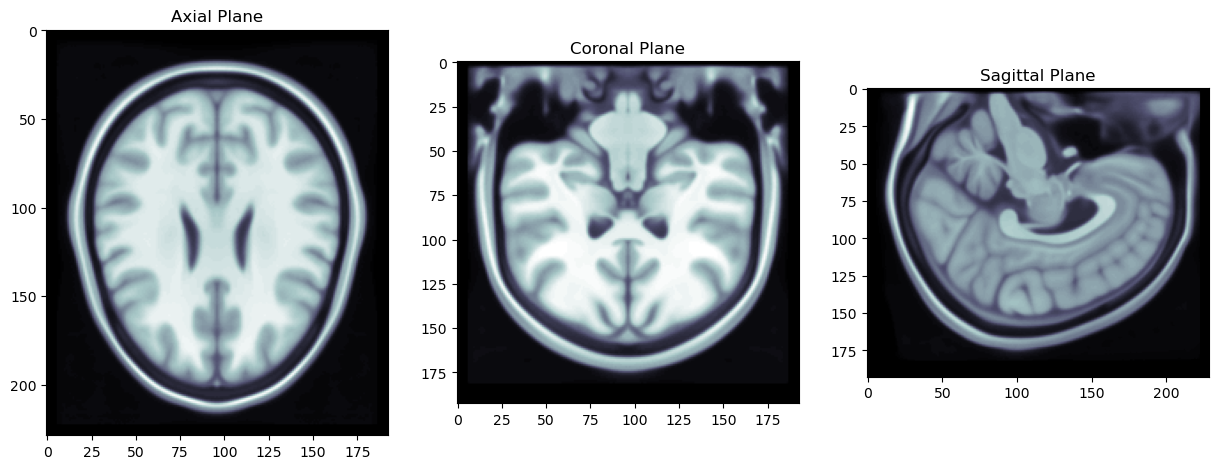

In [99]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(ref_img.pixel_array[100, :, :], cmap='bone')
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(ref_img.pixel_array[:,100, :], cmap='bone')
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(ref_img.pixel_array[:, :, 100], cmap='bone')
plt.title("Sagittal Plane")

plt.show()

In [100]:
pixel_data = {}
def load_and_sort_dicom_images(folder_path):
    """
    Load DICOM files from a specified folder, sort them based on the SliceLocation, and create a 3D numpy array of pixel data.
    
    Parameters:
    - folder_path (str): Path to the folder containing DICOM files.
    
    Returns:
    - np.ndarray: 3D numpy array representing the brain volume.
    """
    # Load all DICOM files
    dicom_files = glob.glob(os.path.join(folder_path, '*.dcm'))
    pixel_data = {}
    for file in dicom_files:
        dicom = pydicom.dcmread(file)
        pixel_data[float(dicom.SliceLocation)] = dicom.pixel_array
    
    # Sort slices and stack into a 3D array
    sorted_slices = sorted(pixel_data.items())
    brain_volume = np.stack([data for _, data in sorted_slices])
    
    return brain_volume

def visualize_slices(brain_volume):
    """
    Visualize axial, coronal, and sagittal planes of a brain volume using matplotlib.
    
    Parameters:
    - brain_volume (np.ndarray): 3D numpy array of the brain volume.
    """
    plt.figure(figsize=(15, 8))
    
    # Axial plane
    plt.subplot(1, 3, 1)
    plt.imshow(brain_volume[110, :, :], cmap='bone', aspect='equal')
    plt.title("Axial Plane")
    plt.title(f"Axial Plane - Shape: {brain_volume[110, :, :].shape}")
    
    # Coronal plane
    plt.subplot(1, 3, 2)
    plt.imshow(brain_volume[:, 200, :], cmap='bone', aspect='equal')
    plt.title("Coronal Plane")
    plt.title(f"Coronal Plane - Shape: {brain_volume[:, 200, :].shape}")
    
    
    # Sagittal plane
    plt.subplot(1, 3, 3)
    plt.imshow(brain_volume[:, :, 250], cmap='bone', aspect='equal')
    plt.title("Sagittal Plane")
    plt.title(f"Sagittal Plane - Shape: {brain_volume[:, :, 250].shape}")
    
    plt.show()



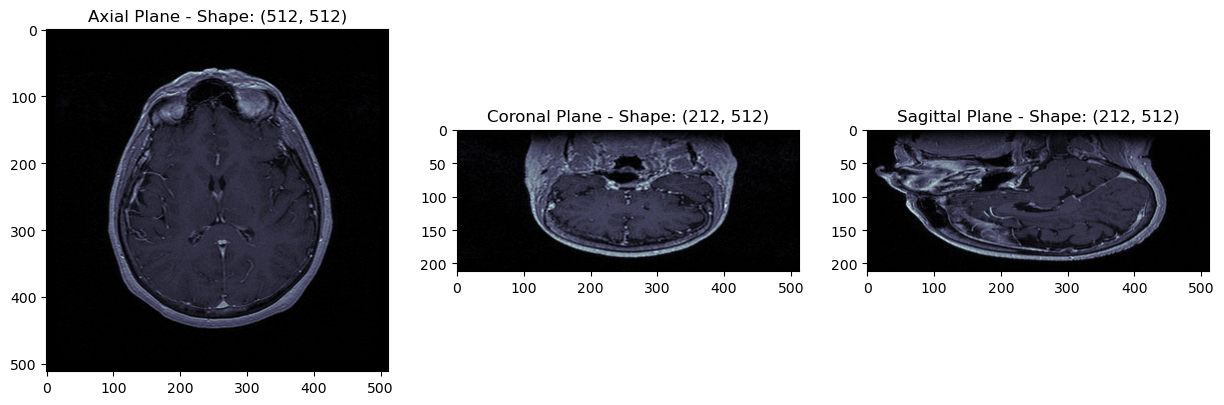

In [101]:
# Usage
folder_path = '../data/brain/RM_Brain_3D-SPGR'
brain_volume = load_and_sort_dicom_images(folder_path)
visualize_slices(brain_volume)

In [102]:
def dicom2csv(extract = [],
              move_on = [(0x7FE0,0x0008), (0x7FE0,0x0009), (0x7FE0,0x0010)],
              folder_path = str(),
              csv_file_name = "metadata.csv",
              return_dataframe = False):
  
    '''
    Extract specific DICOM metadata from multiple DICOM files collected in a
    specified folder.
    ::Params
      - extract (list):
          The keywords of the DICOM attributes you want to extract.
      - move_on (list):
          The tags of the DICOM attributes you don't want to move on.
          By default,it contains a list of the tags of pixel data:
          [(0x7FE0,0x0008), (0x7FE0,0x0009), (0x7FE0,0x0010)]
          If you want to move on onto some attributes, it's recommended
          to append its unique tags in addition to pixel data tags.
      - folder_path (string):
          Path of the folder that contains the DICOM files.
      - csv_file_name (string):
          The name of the CSV file.
      - return_dataframe (bool):
          if True, returns a pandas dataframe of the extracted data for
          direct use.

    :: Returns
      - CSV file contains DICOM metadata specified the parameter extracted.
      - Pandas dataframe when return_dataframe is set to True.

    :: Example:
      dicom2csv(extract = ['StudyDate'],
                folder_path = 'content/dicomfolder',
                csv_file_name = "Study_Dates.csv",
                return_dataframe = True)
    '''
  
    # Initialize the meta dictionary that will have the specified attributes
    meta = {keyword:[] for keyword in extract}

    # List the files' names that we want to extract data from
    #dicom_files = glob.glob(folder_path+'/*.dcm')
    dicom_files = glob.glob(folder_path)

    # Iterate over each DICOM file in the folder and read it using dcmread()
    for file_path in dicom_files:
        # Read the DICOM file from the specified path
        dcm = dicom.dcmread(file_path)

        # Iterate over the DICOM attributes in the current DICOM file "dcm"
        for elem in dcm.iterall():
            # Ensure that the attribute is not a pixel data and it's one of the
            # required attributes
            if (elem.tag not in move_on) and (elem.keyword in extract):
                # Append the value of the current attribute
                meta[elem.keyword].append(elem.value)
            if (elem.tag not in move_on) and (elem.tag in extract):
                # Append the value of the current attribute
                meta[elem.keyword].append(elem.value)
            

    # Create a pandas dataframe for better use of the data
    df = pd.DataFrame(data=meta, columns = extract)

    # Create the CSV file with the specified name
    df.to_csv(csv_file_name, index=False)

    # Return the extracted dataframe for direct use
    if return_dataframe:
        return df

In [103]:
extract = ['SliceLocation', 'SliceThickness', 'SpacingBetweenSlices', 'ImagePositionPatient', 'InstanceNumber', 'PixelSpacing']
df = dicom2csv(extract = extract,
               move_on = [],
               folder_path = patient_img_folder,
               csv_file_name = 'data.csv', 
               return_dataframe = True)
df.head()

SliceLocation  SliceThickness  SpacingBetweenSlices  \
0     -17.940765             2.0                   1.0   
1     -17.940765             2.0                   1.0   
2      17.059235             2.0                   1.0   
3      17.059235             2.0                   1.0   
4      64.059235             2.0                   1.0   

                ImagePositionPatient  InstanceNumber      PixelSpacing  
0  [-130, -125.9024353, -17.9407654]              95  [0.5078, 0.5078]  
1  [-130, -125.9024353, -17.9407654]              95  [0.5078, 0.5078]  
2   [-130, -125.9024353, 17.0592346]             130  [0.5078, 0.5078]  
3   [-130, -125.9024353, 17.0592346]             130  [0.5078, 0.5078]  
4   [-130, -125.9024353, 64.0592346]             177  [0.5078, 0.5078]

### Visualizing images in different planes

In [104]:
def visualize_planes(image, title_prefix="", slices=(100, 150, 250), aspects=(1, 1, 1)):
    """
    Visualizes axial, coronal, and sagittal planes of a medical image.
    
    Parameters:
    - image (np.ndarray): The medical image to be visualized.
    - title_prefix (str): A prefix for the title to indicate the image type or condition.
    - slices (tuple): Indices of the slices to be displayed (axial, coronal, sagittal).
    - aspects (tuple): Aspect ratios for the axial, coronal, and sagittal planes.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    titles = ["Axial Plane", "Coronal Plane", "Sagittal Plane"]
    for i, ax in enumerate(axes):
        if i == 0:
            ax.imshow(image[slices[i], :, :], cmap='bone', aspect=aspects[i])
        elif i == 1:
            ax.imshow(image[:, slices[i], :], cmap='bone', aspect=aspects[i])
        elif i == 2:
            ax.imshow(image[:, :, slices[i]], cmap='bone', aspect=aspects[i])
        ax.set_title(f"{title_prefix} {titles[i]}")
    plt.show()

def initial_rotation(img_dcm, angle_in_degrees):
    """ Rotates an image around an axis parallel to the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)


In [105]:
brain_volume.shape

(212, 512, 512)

In [106]:
reference_array = ref_img.pixel_array

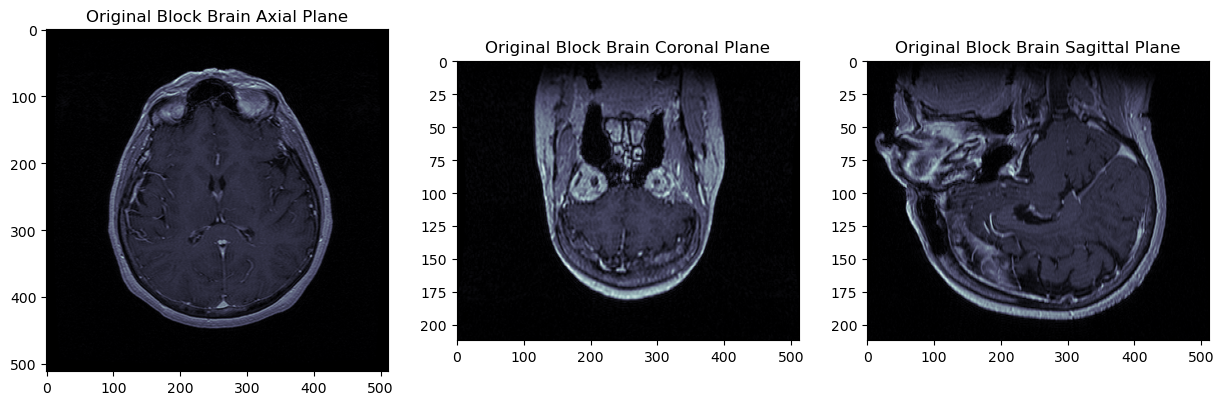

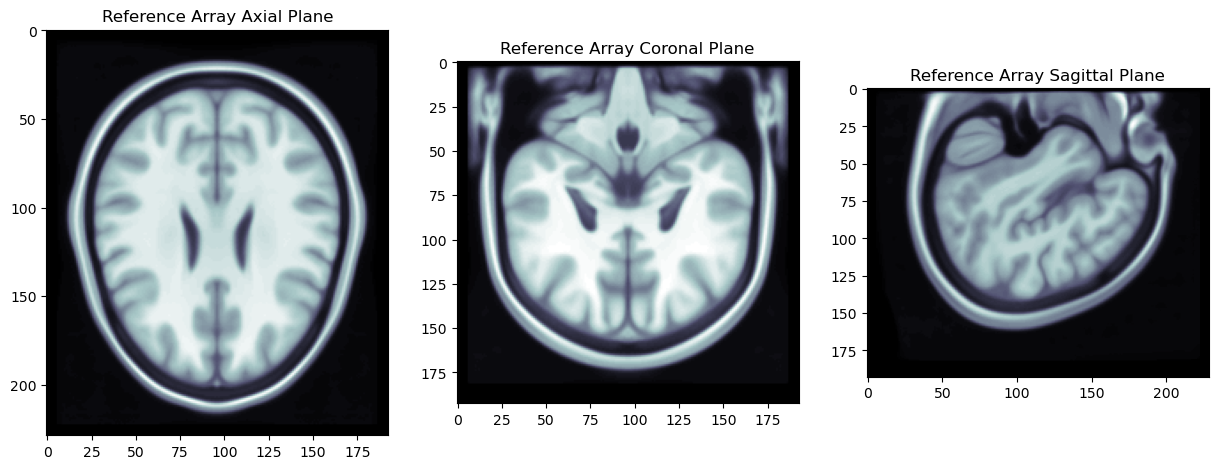

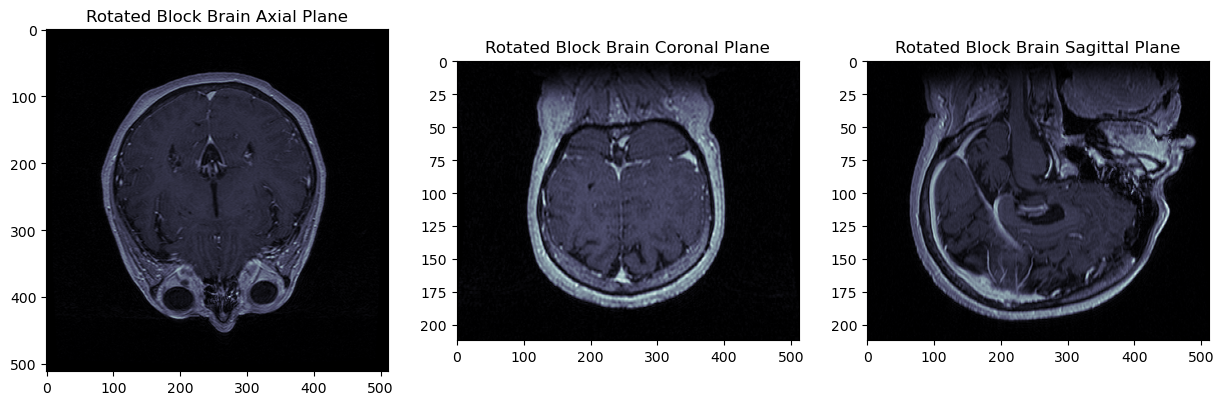

In [107]:
# Visualize the original and reference images
visualize_planes(brain_volume, "Original Block Brain", slices=(110, 150, 250), aspects=(1, 1/0.507, 1/0.507))
visualize_planes(reference_array, "Reference Array", slices=(100, 90, 50), aspects=(1, 1, 1))

# Rotate the image and visualize
rotated_image = initial_rotation(brain_volume, 180)
visualize_planes(rotated_image, "Rotated Block Brain", slices=(100, 150, 250), aspects=(1, 1/0.507, 1/0.507))

### Scale Images according to Reference Image 

Finding the pixel spacing of teh Reference Image

In [109]:
def save_dicom_header_to_file(file_path: str, output_file='dicom_header.txt'):
    dicom_data = pydicom.dcmread(file_path)
    with open(output_file, 'w') as file:
        for element in dicom_data:
            if element.VR != "SQ":
                file.write(f"{element.tag} {element.name}: {element.value}\n")
            else:
                file.write(f"{element.tag} {element.name}: [Sequence]\n")

# Example usage
save_dicom_header_to_file("../data/brain/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm")


In [114]:
def find_attribute(dicom_data, attribute_name):
    """
    Recursively search for an attribute in the DICOM dataset.
    """
    for element in dicom_data:
        if element.VR == "SQ":  # If the element is a sequence
            for item in element:
                result = find_attribute(item, attribute_name)
                if result:
                    return result
        elif element.keyword == attribute_name:
            return element.value
    return None

# Load DICOM file
dicom_data = pydicom.dcmread("../data/brain/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm")

# Search for PixelSpacing
pixel_spacing = find_attribute(dicom_data, 'PixelSpacing')
if pixel_spacing:
    print("Pixel Spacing:", pixel_spacing)
else:
    print("Pixel Spacing not found.")


Pixel Spacing: [1, 1]


In [115]:
def scale_image_to_reference(patient_image, patient_pixel_spacing, reference_pixel_spacing):
    
    scaling_factors = (
        1,  # Typically, no scaling is done along the z-axis unless explicitly needed
        patient_pixel_spacing[0] / reference_pixel_spacing[0],
        patient_pixel_spacing[1] / reference_pixel_spacing[1],
    )
    scaled_image = scipy.ndimage.zoom(patient_image, scaling_factors, order=1)  # order=1 for bilinear interpolation

    return scaled_image


In [116]:
patient_image = rotated_image  
patient_pixel_spacing = [0.507, 0.507]
reference_pixel_spacing = [1, 1]  # From your reference image's metadata

# Scale the patient image to match the reference image
scaled_patient_image = scale_image_to_reference(patient_image, patient_pixel_spacing, reference_pixel_spacing)


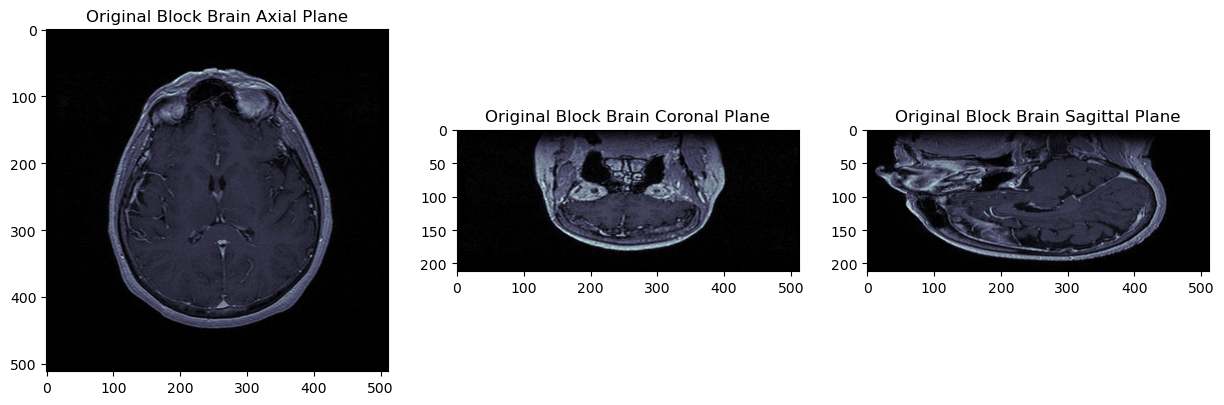

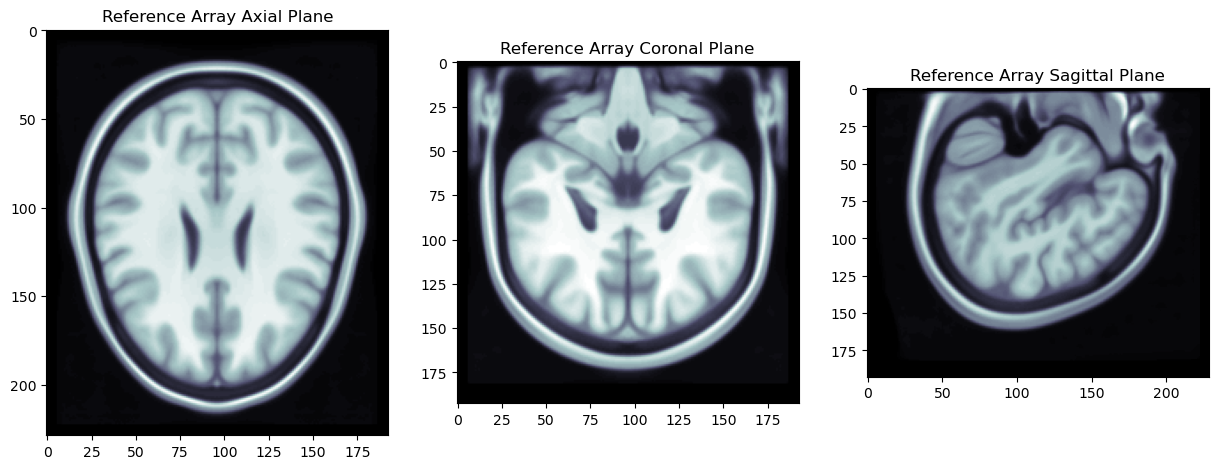

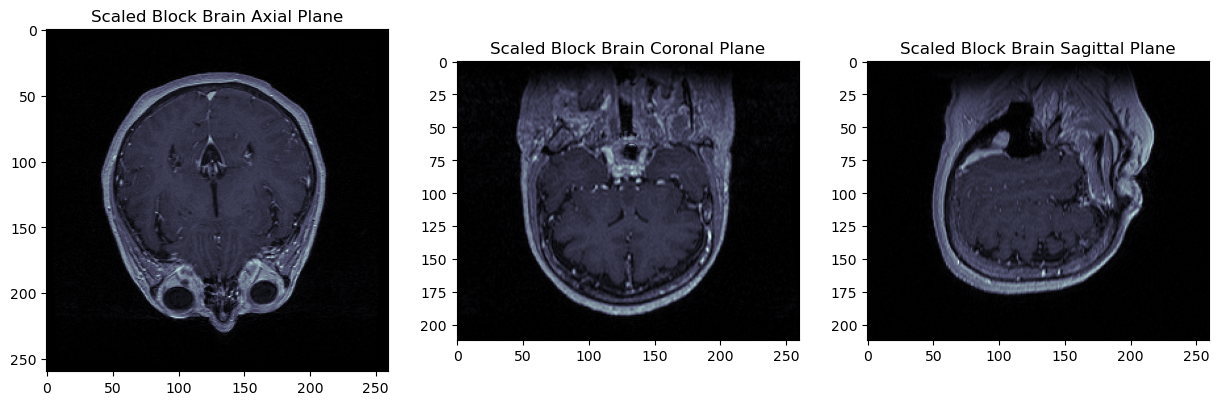

In [117]:
# Visualize the original and reference images
visualize_planes(brain_volume, "Original Block Brain", slices=(110, 150, 250), aspects=(1, 1, 1))
visualize_planes(reference_array, "Reference Array", slices=(100, 90, 50), aspects=(1, 1, 1))
visualize_planes(scaled_patient_image, "Scaled Block Brain", slices=(100, 150, 180), aspects=(1, 1, 1))

### Cropping Image to match the shape of reference image

In [118]:
scaled_patient_image.shape

(212, 260, 260)

In [119]:
def crop_to_match(image, target_shape):
    """
    Crop the 3D image to match the specified target shape.

    Parameters:
    - image (np.ndarray): The 3D image to be cropped.
    - target_shape (tuple): The target dimensions (z, y, x).

    Returns:
    - np.ndarray: The cropped image.
    """
    z, y, x = image.shape
    target_z, target_y, target_x = target_shape

    # Calculate the start and end indices for cropping each dimension
    start_z = (z - target_z) // 2
    end_z = start_z + target_z

    start_y = (y - target_y) // 2
    end_y = start_y + target_y

    start_x = (x - target_x) // 2
    end_x = start_x + target_x

    # Perform the cropping
    cropped_image = image[start_z:end_z, start_y:end_y, start_x:end_x]
    return cropped_image


In [120]:
final_cropped_image = crop_to_match(scaled_patient_image, (193, 229, 193))


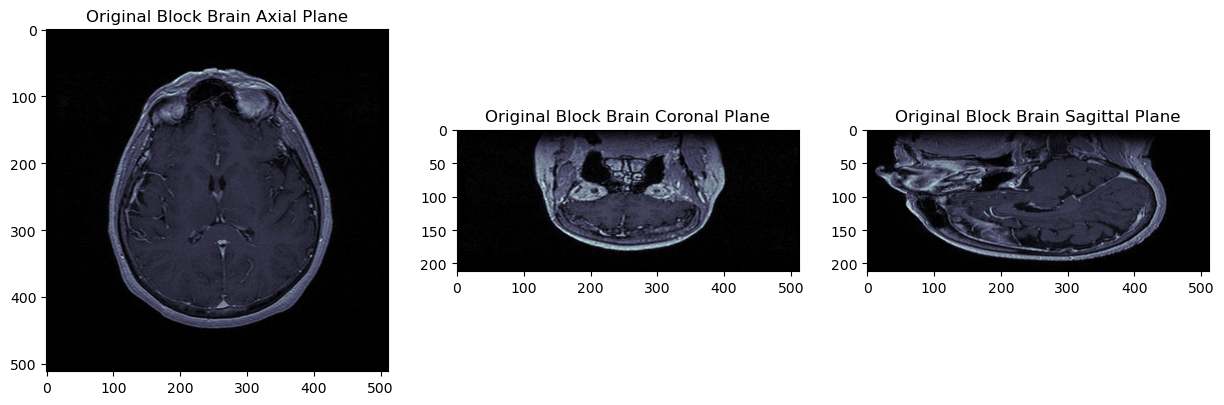

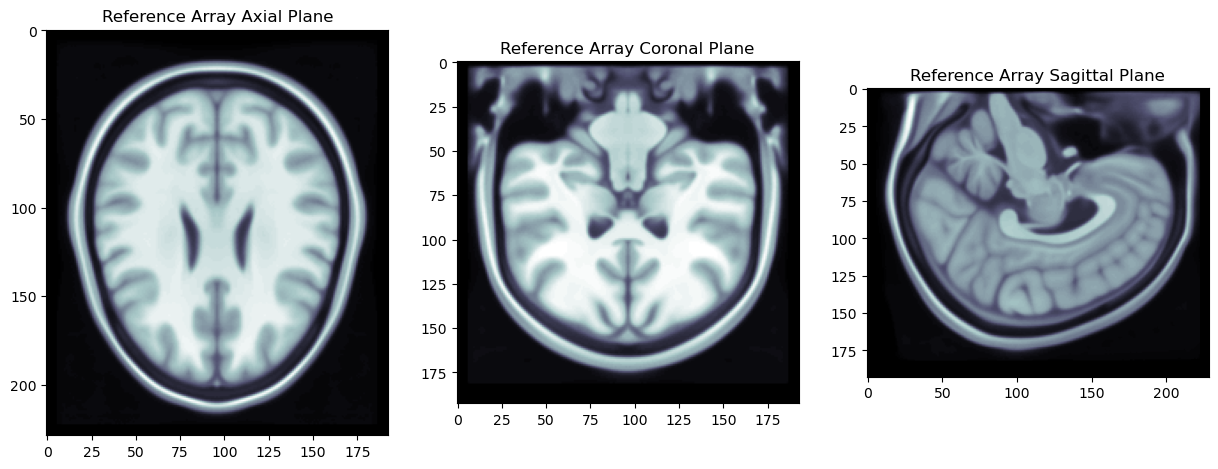

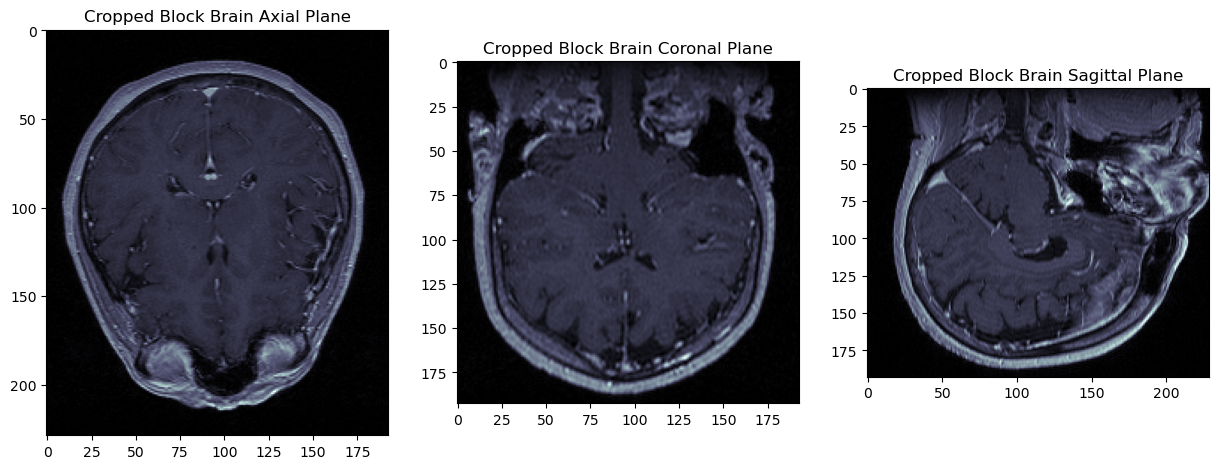

In [121]:
# Visualize the original and reference images
visualize_planes(brain_volume, "Original Block Brain", slices=(110, 150, 250), aspects=(1, 1, 1))
visualize_planes(reference_array, "Reference Array", slices=(100, 100, 100), aspects=(1, 1, 1))
visualize_planes(final_cropped_image, "Cropped Block Brain", slices=(100, 100, 100), aspects=(1, 1, 1))

In [122]:
final_cropped_image.shape

(193, 229, 193)

### Co-registration

In [57]:
def translate_img(image, translations):
    translated_image = np.roll(image, translations.astype(int), axis=(0, 1, 2))
    return translated_image

def rotate_img(image, angles):
    #axial
    result = scipy.ndimage.rotate(image, angles[0]*180/np.pi, axes=(1, 2), reshape=False)
    #coronal
    result = scipy.ndimage.rotate(image, angles[1]*180/np.pi, axes=(0, 2), reshape=False)
    #sagittal
    result = scipy.ndimage.rotate(image, angles[2]*180/np.pi, axes=(0, 1), reshape=False)
    return result

In [58]:
def mse(ref_img, inp_img):
    return np.mean(((ref_img-inp_img))**2)

def normalize(input_array):
    min_val = np.min(input_array)
    max_val = np.max(input_array)

    # Perform min-max normalization
    normalized_array = (input_array - min_val) / (max_val - min_val)
    return normalized_array

def find_centroid_volume(volume):
    idcs = np.where(volume != 0)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

In [59]:
errors = []
def coregister_img(ref_image: np.ndarray, inp_image: np.ndarray, optimizer="GD"):
    """ Coregister two sets of landmarks using a rigid transformation. """
    c_ref = find_centroid_volume(ref_image)
    c_inp = find_centroid_volume(inp_image)
    
    translation_vector = c_inp - c_ref
    initial_parameters = [
        translation_vector[0], translation_vector[1], translation_vector[2],    # Translation vector
        np.pi, 0, 0         # Rotation Angles in rads
    ]
    
    def function_to_minimize(parameters):
        input_image = translate_img(inp_image, parameters[0:3])
        input_image = rotate_img(input_image, parameters[3:])
        error = mse(ref_image, input_image)
        errors.append(error)
        return error
    
    
    if optimizer == "GD":
        # Apply gradient descent optimization
        result = minimize(
            function_to_minimize,
            x0=initial_parameters)
    else:
        # Apply least squares optimization
        print( initial_parameters)
        result = least_squares(
            function_to_minimize,
            x0=initial_parameters,
            verbose=1)
    return result

In [60]:
# least squares 
result = coregister_img(normalize(reference_array), normalize(final_cropped_image), "LS")
solution_found = result.x

[5.213292788172012, -1.5618851507042564, -0.005968361261807331, 3.141592653589793, 0, 0]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
`ftol` termination condition is satisfied.
Function evaluations 18, initial cost 1.5547e-03, final cost 1.5353e-03, first-order optimality 1.14e-05.


In [61]:
least_squares_result = result.x
least_squares_result

array([ 5.21329279e+00, -1.56188515e+00, -5.96836126e-03,  3.14159265e+00,
        0.00000000e+00,  6.38377624e+00])

In [62]:
parameters = np.array([5.21329279e+00, -1.56188515e+00, -5.96836126e-03,  3.14159265,  0.        ,0])
transformed_img = translate_img(block_brain, parameters[0:3])
transformed_img = scipy.ndimage.rotate(transformed_img , 180, axes=(1, 2), reshape=False)


In [63]:
transformed_img.shape

(212, 512, 512)

In [64]:
# Scale the patient image to match the reference image
scaled_transformed_image = scale_image_to_reference(transformed_img, patient_pixel_spacing, reference_pixel_spacing)

In [65]:
scaled_transformed_image.shape

(212, 260, 260)

In [66]:
final_cropped_transformed_image = crop_to_match(scaled_transformed_image, (193, 229, 193))

In [67]:
final_cropped_transformed_image.shape

(193, 229, 193)

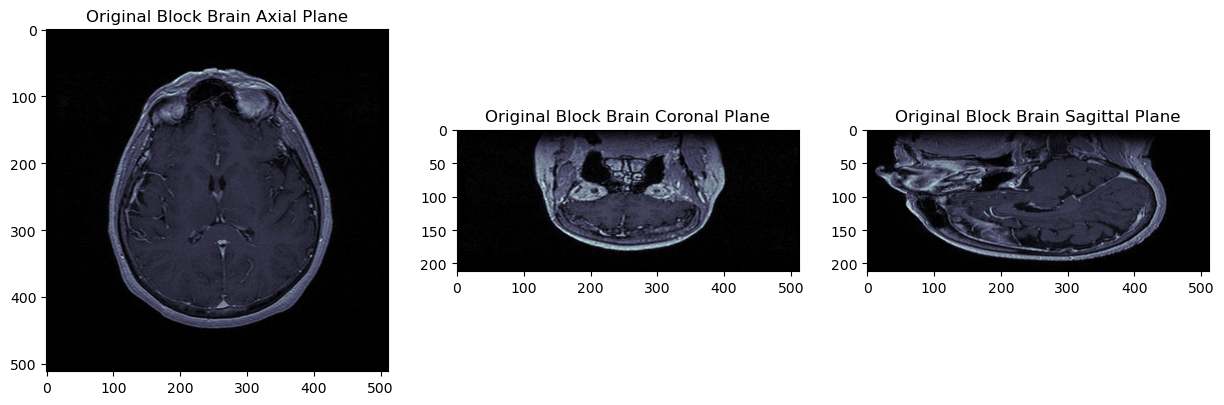

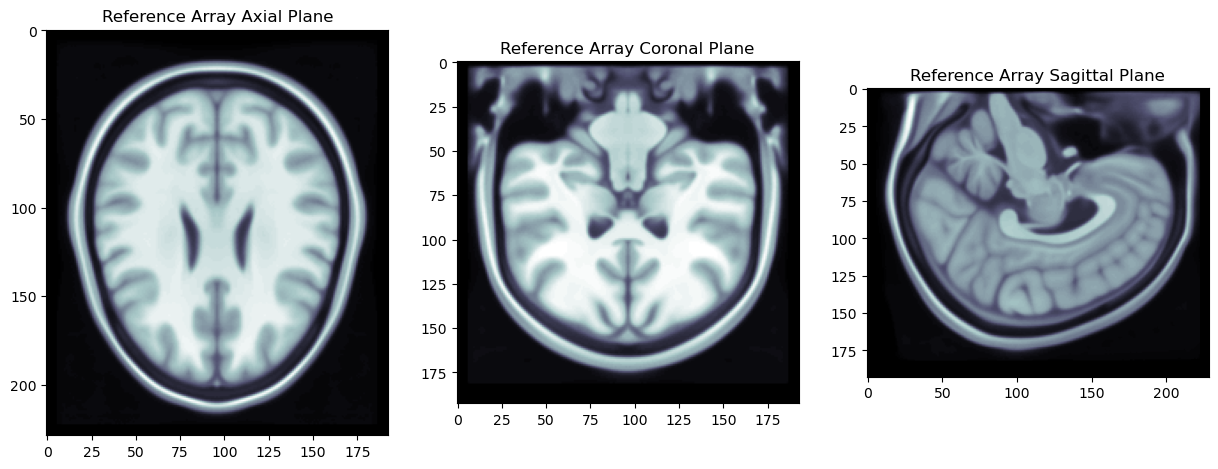

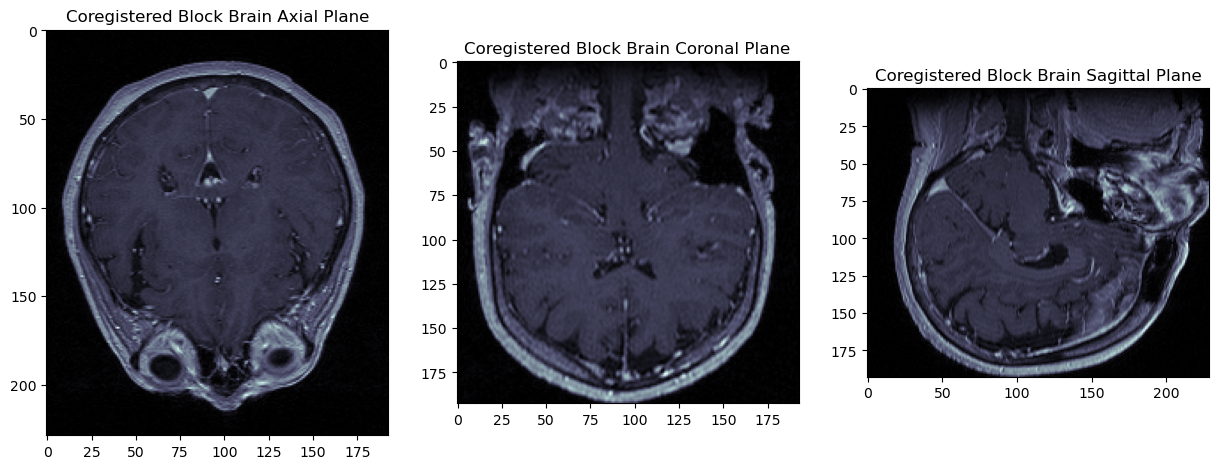

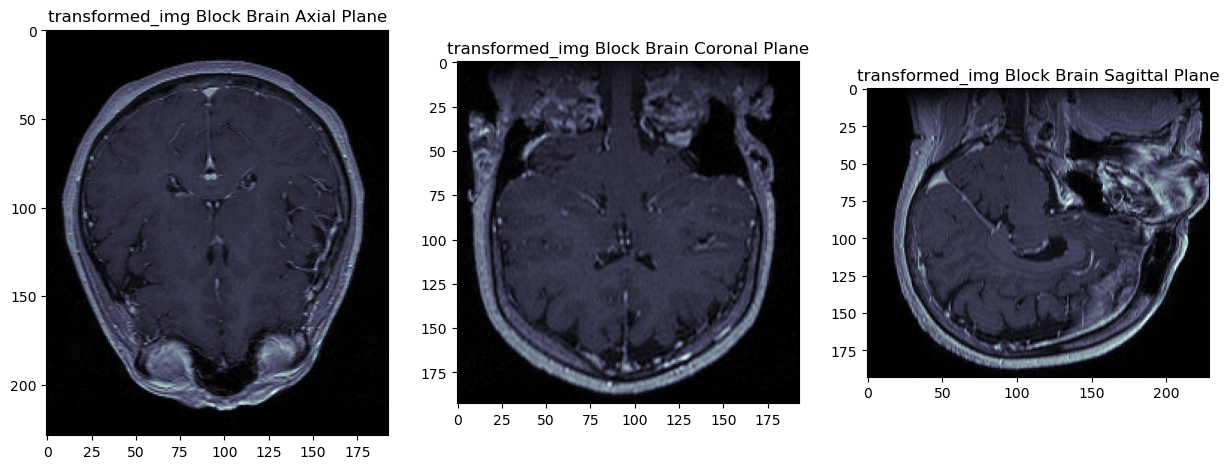

In [70]:
# Visualize the original and reference images
visualize_planes(brain_volume, "Original Block Brain", slices=(110, 150, 250), aspects=(1, 1, 1))
visualize_planes(reference_array, "Reference Array", slices=(100, 100, 100), aspects=(1, 1, 1))
visualize_planes(final_cropped_transformed_image, "Coregistered Block Brain", slices=(100, 100, 100), aspects=(1, 1, 1))

### Finding Thalamus

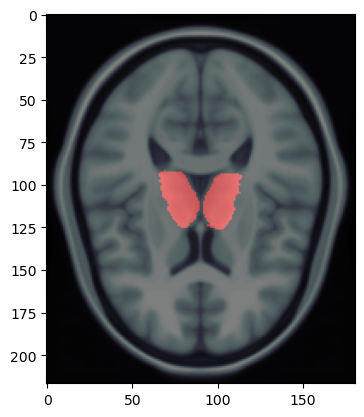

/var/folders/n7/_glswg257gdgt_85w9wly1cw0000gn/T/ipykernel_49270/1412324674.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Volume of the region: 16699 mm³
Surface of the region: 3996.5 mm²


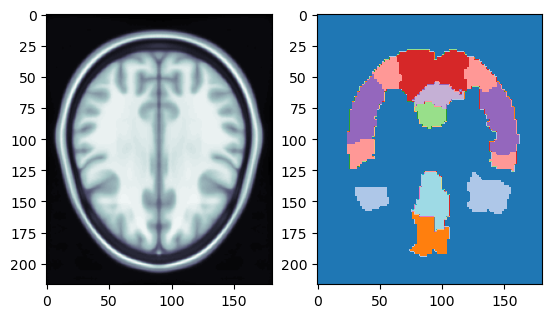

In [123]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pydicom as dicom
from skimage.morphology import binary_dilation, binary_erosion

# Function Definitions

def get_thalamus_mask(img_atlas: np.ndarray) -> np.ndarray:
    """Extract the thalamus region as a binary mask."""
    mask = np.zeros_like(img_atlas)
    for i in range(121, 151):  # IDs corresponding to the thalamus
        mask[img_atlas == i] = 1
    return mask

def find_centroid(mask: np.ndarray) -> np.ndarray:
    """Calculate the centroid of a binary mask."""
    idcs = np.where(mask == 1)
    centroid = np.stack([np.mean(idcs[dim]) for dim in range(3)])
    return centroid

def visualize_axial_slice(img: np.ndarray, mask: np.ndarray, mask_centroid: np.ndarray):
    """Visualize the axial slice of the image with a mask overlay."""
    img_slice = img[int(mask_centroid[0]), :, :]
    mask_slice = mask[int(mask_centroid[0]), :, :]
    cmap = matplotlib.cm.get_cmap('bone')
    norm = matplotlib.colors.Normalize(vmin=np.min(img_slice), vmax=np.max(img_slice))
    fused_slice = 0.5 * cmap(norm(img_slice))[..., :3] + 0.5 * np.stack([mask_slice, np.zeros_like(mask_slice), np.zeros_like(mask_slice)], axis=-1)
    plt.imshow(fused_slice)
    plt.show()

def find_region_volume(region_mask: np.ndarray) -> int:
    """Calculate the volume of the region, assuming each voxel represents 1mm³."""
    return np.sum(region_mask)

def find_region_surface(mask: np.ndarray) -> float:
    """Estimate the surface area of the region by calculating the boundary voxels."""
    inner_surface = mask - binary_erosion(mask)
    outer_surface = binary_dilation(mask) - mask
    return (np.sum(inner_surface) + np.sum(outer_surface)) / 2

# Load Data
atlas_path = "../data/brain/AAL3_1mm.dcm"
dcm_atlas = dicom.dcmread(atlas_path)
img_atlas = dcm_atlas.pixel_array

dcm_phantom = dicom.dcmread("../data/brain/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm")
img_phantom = dcm_phantom.pixel_array[6:-6, 6:-6, 6:-6]  # Crop to match atlas size

# Processing
mask = get_thalamus_mask(img_atlas)
mask_centroid = find_centroid(mask)

# Visualization
visualize_axial_slice(img_phantom, mask, mask_centroid)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_phantom[100, :, :], cmap='bone')
axs[1].imshow(img_atlas[100, :, :], cmap='tab20')
fig.show()

# Metrics Calculation
vol = find_region_volume(mask)
surf = find_region_surface(mask)
print(f"Volume of the region: {vol} mm³")
print(f"Surface of the region: {surf} mm²")


In [124]:
img_phantom.shape

(181, 217, 181)

In [125]:
mask.shape

(181, 217, 181)

In [126]:
block_brain.shape[0]

212

In [127]:
def adjust_mask(mask, target_shape, pad_start=(6, 6, 6), parameters=None):
    # Calculate padding needed
    pad_channels = target_shape[0] - mask.shape[0]
    pad_height = target_shape[1] - mask.shape[1]
    pad_width = target_shape[2] - mask.shape[2]

    # Apply padding
    padded_mask = np.pad(mask, ((pad_start[0], pad_channels-pad_start[0]), 
                                (pad_start[1], pad_height-pad_start[1]), 
                                (pad_start[2], pad_width-pad_start[2])), 
                         mode='constant')

    # Apply transformations
    if parameters is not None:
        padded_mask = rotate_img(padded_mask, parameters[3:])
        padded_mask = translate_img(padded_mask, parameters[:3])

    return padded_mask

final_cropped_image_shape = final_cropped_image.shape
mask = get_thalamus_mask(img_atlas)
parameters = np.array([5.21329279, -1.56188515, -0.00596836, 3.14159265, 0, 0])

# Adjust the mask to fit the final cropped image and apply transformations
padded_mask = adjust_mask(mask, final_cropped_image_shape, parameters=parameters)
print("Adjusted mask shape:", padded_mask.shape)

Adjusted mask shape: (193, 229, 193)


In [128]:
mask_centroid_transformed = find_centroid(padded_mask)

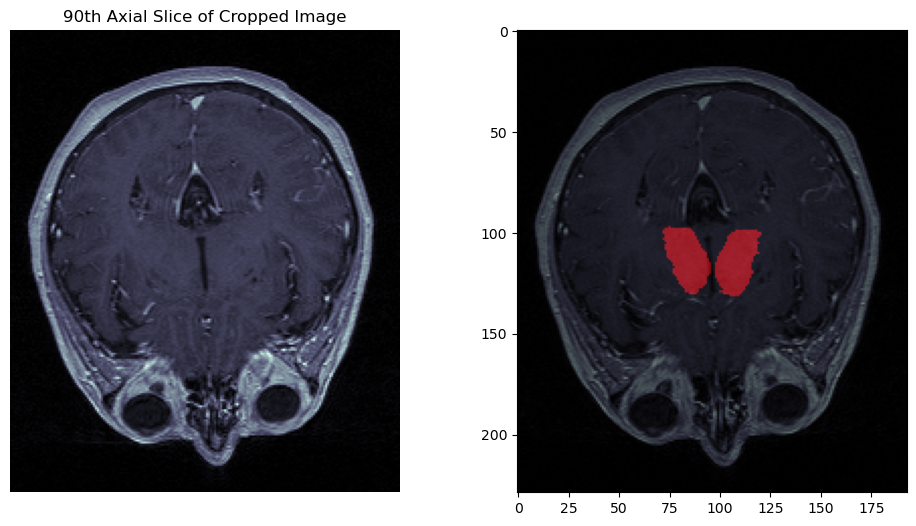

<Figure size 640x480 with 0 Axes>

In [129]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the 90th axial slice of the final cropped image
axs[0].imshow(final_cropped_image[90, :, :], cmap='bone')
axs[0].set_title('90th Axial Slice of Cropped Image')
axs[0].axis('off')  # Hide axes for cleaner visualization

# Visualize the axial slice with the mask overlay
visualize_axial_slice(final_cropped_image, padded_mask, mask_centroid_transformed)

plt.tight_layout()
plt.show()
